In [13]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import kneighbors_graph

def visualize_neighbors_graph(Z, n_neighbors=3):
    """
    Visualizes the nearest-neighbor graph for a given set of points.

    Parameters:
        Z (np.ndarray): The data points to use for building the nearest-neighbor graph (shape: n_samples x n_features).
        n_neighbors (int): The number of neighbors to connect each point to in the graph.
    """
    # Step 1: Compute the nearest neighbor graph
    graph = kneighbors_graph(Z, n_neighbors=n_neighbors, mode='connectivity')

    # Step 2: Convert the sparse graph to a NetworkX graph
    graph = graph.toarray()  # Convert to dense format
    G = nx.from_numpy_array(graph)  # Create a NetworkX graph from the matrix

    # Step 3: Visualize the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, seed=42)  # Use spring layout for better visualization
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, font_size=10, font_weight='bold', edge_color='gray')

    # Show the plot
    plt.title(f'Nearest-Neighbor Graph (k={n_neighbors})')
    plt.show()


In [14]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.linalg import qr
from scipy.sparse.csgraph import connected_components  # For connected components

def init_alg(N0, d, k, stream):
    """
    Implementation of InitAlg(N0) for initializing cluster centers.

    Parameters:
        N0 (int): Number of initial data points for initialization.
        d (int): Dimensionality of the data.
        k (int): Number of clusters.
        stream (generator): A generator that yields data points sequentially.

    Returns:
        np.ndarray: Initial cluster centers of shape (k, d).
    """
    # Step 1: Initialization
    U = np.linalg.qr(np.random.randn(d, k))[0]  # Random orthonormal matrix U (QR decomposition)
    B = int(d * np.log(d))  # Batch size
    S = np.zeros((d, d))  # Accumulator for second moments

    # Step 2: Process the first N0 - k * log k points
    for t in range(1, N0 - k * int(np.log(k)) + 1):
        if t % B == 0:
            # Periodic QR decomposition update
            U = qr(S @ U, mode='economic')[0]
            S = np.zeros((d, d))  # Reset S

        x_t = next(stream)  # Receive the next data point from the stream
        S += np.outer(x_t, x_t)  # Update second moment

    # Step 3: Collect the last k * log k data points
    X0 = []
    for _ in range(k * int(np.log(k))+1):
        X0.append(next(stream))
    X0 = np.array(X0).T  # Shape: (d, k log k)
    print(X0)

    # Step 4: Project data into reduced space
    Z = U.T @ X0  # Shape: (k, k log k)
    print(Z)

    # Step 5: Form nearest-neighbor graph
    graph = kneighbors_graph(Z.T, n_neighbors=1, mode='connectivity', include_self=True)  # Nearest neighbor graph
    visualize_neighbors_graph(Z.T, n_neighbors=1)

    # Step 6: Find connected components
    n_components, labels = connected_components(graph, directed=False, return_labels=True)

    print(n_components)

    # Step 7: Compute cluster centers in reduced space
    cluster_centers = []
    for i in range(n_components):
        component_points = Z[:, labels == i]  # Points in the current connected component
        cluster_centers.append(np.mean(component_points, axis=1))  # Mean in reduced space
    cluster_centers = np.array(cluster_centers).T  # Shape: (k, d)

    # Step 8: Transform back to original space
    mu = U @ cluster_centers  # Shape: (d, k)

    return mu.T  # Shape: (k, d)



In [15]:
def find_connected_components(graph):
    """
    Helper function to find connected components in a graph.

    Parameters:
        graph (scipy.sparse.csr_matrix): Nearest neighbor graph (sparse matrix).

    Returns:
        list of lists: Connected components as lists of point indices.
    """
    from scipy.sparse.csgraph import connected_components

    n_components, labels = connected_components(csgraph=graph, directed=False)
    components = [[] for _ in range(n_components)]
    for idx, label in enumerate(labels):
        components[label].append(idx)
    return components

In [16]:
def stream_kmeans(N, N0, d, k, stream):
    """
    Implementation of StreamKmeans(N, N0) for streaming k-means clustering.

    Parameters:
        N (int): Total number of data points in the stream.
        N0 (int): Number of initial points for initialization.
        d (int): Dimensionality of the data.
        k (int): Number of clusters.
        stream (generator): A generator that yields data points sequentially.
        init_alg (function): Function to initialize cluster centers.

    Returns:
        np.ndarray: Final cluster centers of shape (k, d).
    """
    # Step 1: Compute learning rate
    eta = (3 * k * np.log(3 * N)) / N

    # Step 2: Initialize cluster centers using InitAlg(N0)
    cluster_centers = init_alg(N0, d, k, stream)  # Shape: (k, d)
    print(cluster_centers)

    # Step 3: Streaming updates
    for t in range(1, N + 1):
        x = next(stream)  # Get the next data point

        # Step 4: Find the nearest cluster center
        distances = np.linalg.norm(cluster_centers - x, axis=1)
        i_t = np.argmin(distances)

        # Step 5: Update the assigned cluster center
        cluster_centers[i_t] = (1 - eta) * cluster_centers[i_t] + eta * x

    return cluster_centers

In [17]:
def gaussian_data_stream(means, covs, points_per_cluster):
    """
    Generate a stream of data points sampled from k 2D Gaussian distributions.

    Parameters:
        means (list of np.ndarray): List of mean vectors for each Gaussian (2D).
        covs (list of np.ndarray): List of covariance matrices for each Gaussian (2D).
        points_per_cluster (int): Number of points per cluster.

    Yields:
        np.ndarray: A random 2D data point sampled from one of the Gaussians.
    """
    k = len(means)
    cluster_sizes = [points_per_cluster] * k
    while True:
        # Randomly choose a Gaussian distribution
        cluster = np.random.choice(k)
        # Sample a point from the chosen Gaussian
        yield np.random.multivariate_normal(means[cluster], covs[cluster])


[[-15.59358984  30.05564621   0.75746694  30.59452874 -16.37649765]
 [  0.33093346  30.70579422   0.53200096  29.91605515  13.7681226 ]]
[[ 1.11329102e+01  9.63903735e-01 -1.48717265e-01  2.24094244e-02
   2.12923527e+01]
 [-1.09237297e+01  4.29564728e+01  9.13599667e-01  4.27901279e+01
  -2.09441913e+00]]


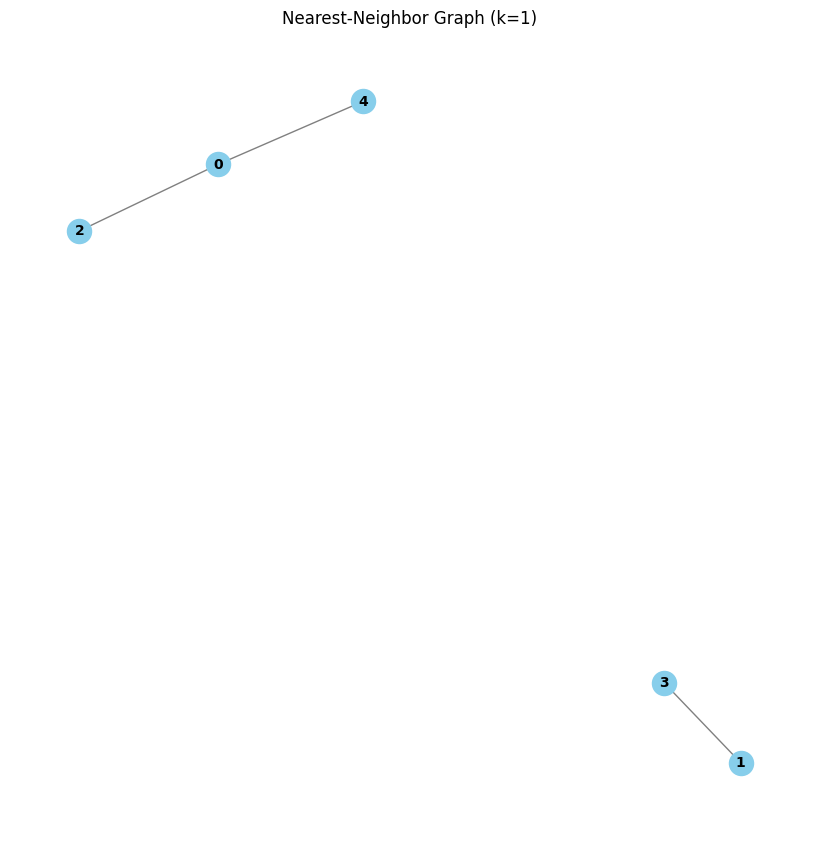

5
[[-15.59358984   0.33093346]
 [ 30.05564621  30.70579422]
 [  0.75746694   0.53200096]
 [ 30.59452874  29.91605515]
 [-16.37649765  13.7681226 ]]
True Centers:
[[-15   0]
 [ 10  10]
 [-15  15]
 [  5  -7]
 [ 30  30]
 [  0   0]]
Estimated Centers:
[[-1.48460404e+01  2.39198393e-02]
 [ 2.98692728e+01  3.08302981e+01]
 [ 5.51281485e+00  7.22177824e-01]
 [ 2.99140876e+01  2.93559822e+01]
 [-1.50590790e+01  1.50384973e+01]]


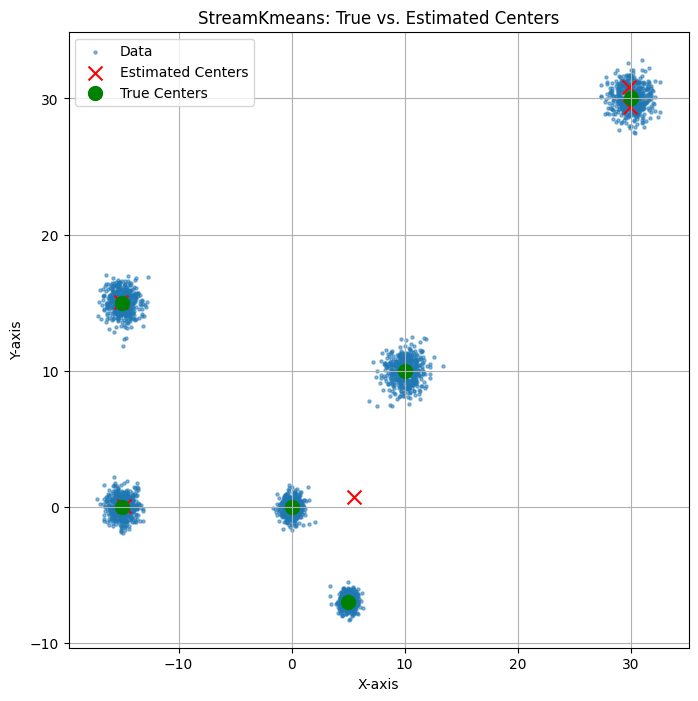

In [18]:
import matplotlib.pyplot as plt

# Parameters for the Gaussians
true_means = [np.array([-15, 0]), np.array([10, 10]), np.array([-15, 15]), np.array([5,-7]), np.array([30,30]), np.array([0,0])]  # True centers
true_covs = [np.eye(2) * 0.5, np.eye(2) * 0.8, np.eye(2) * 0.6, np.eye(2)*0.2, np.eye(2)*0.9, np.eye(2)*0.3]       # Covariance matrices
points_per_cluster = 1000

# Stream generator
stream = gaussian_data_stream(true_means, true_covs, points_per_cluster)

# StreamKmeans parameters
N = 3000  # Total number of points (matches points_per_cluster * len(true_means))
N0 = 300  # Number of initial points for InitAlg
d = 2     # Dimensionality of the data
k = 4     # Number of clusters

# Run StreamKmeans
final_centers = stream_kmeans(N, N0, d, k, stream)


# Print and visualize the results
print("True Centers:")
print(np.array(true_means))
print("Estimated Centers:")
print(final_centers)

# Generate data for visualization
sampled_data = np.array([next(stream) for _ in range(N)])
plt.figure(figsize=(8, 8))
plt.scatter(sampled_data[:, 0], sampled_data[:, 1], s=5, alpha=0.5, label="Data")
plt.scatter(final_centers[:, 0], final_centers[:, 1], color='red', label="Estimated Centers", marker='x', s=100)
plt.scatter(np.array(true_means)[:, 0], np.array(true_means)[:, 1], color='green', label="True Centers", marker='o', s=100)
plt.legend()
plt.title("StreamKmeans: True vs. Estimated Centers")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.show()